In [1]:
import sys
sys.path.append("../../")
from mfmodeling import NARGP, SingleGP
import pickle

# Set kernel name to use
# KERNEL_NAME = "RBF"
# KERNEL_NAME = "SpectralMixture"
KERNEL_NAME = "NeuralKernelNetwork"

2024-10-26 04:03:16.042516: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-26 04:03:16.140368: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-26 04:03:16.145512: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/smaeyama/mylib/netcdf-fortran-4.6.1-ifx/lib:/opt/intel/oneapi/tbb/2021.12/env/../lib/intel64/gcc4.8:/

### Read dataset

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import optimize

df = pd.read_csv("./data/JET_data_Narita2023CPP_fig1.csv")
df = df[df["D_exp"]>0].copy()
print(df.columns)

D_exp_threshold = df["D_exp"].median()

df_train = df[df["D_exp"]>D_exp_threshold].copy()
df_test = df[df["D_exp"]<=D_exp_threshold].copy()
print(df.shape)
print(df_train.shape)
print(df_test.shape)

Index(['R/Ln', 'R/LTe', 'R/LTi', 'ni/ne', 'Te/Ti', 'beta', 'nu_ee', 'q', 's',
       'epsilon', 'kappa', 'delta', 'C_T', 'C_P', 'C_N', 'C_HP',
       'chi_e_eff/chi_i_eff', 'ktheta', 'gamma', 'D_exp', 'Q_e_exp'],
      dtype='object')
(135, 21)
(67, 21)
(68, 21)


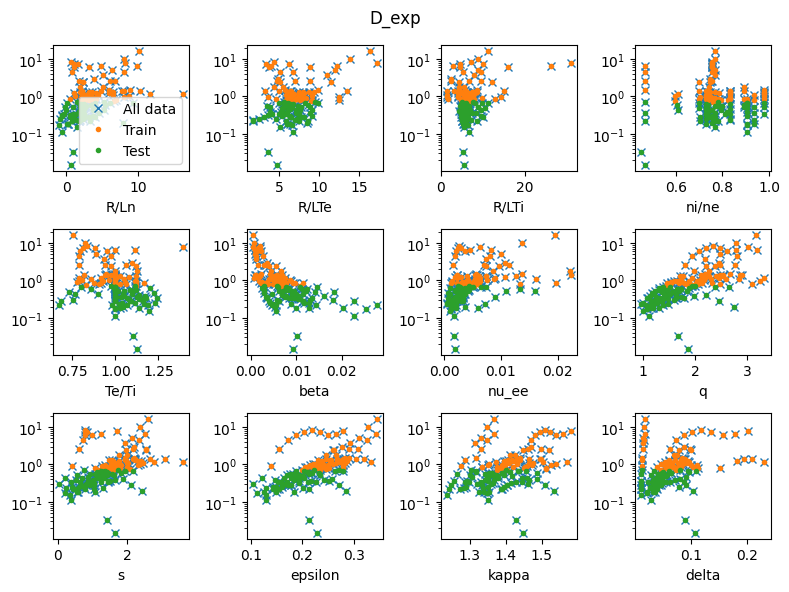

In [3]:
fig = plt.figure(figsize=(8,6))
fig.suptitle("D_exp")
nl=3; nc=4; i=0
for l in range(nl):
    for c in range(nc):
        ax = fig.add_subplot(nl,nc,1+i)
        ax.plot(df.iloc[:,i],df["D_exp"],"x",label="All data")
        ax.plot(df_train.iloc[:,i],df_train["D_exp"],".",label="Train")
        ax.plot(df_test.iloc[:,i],df_test["D_exp"],".",label="Test")
        ax.set_xlabel(df_train.columns[i])
        # ax.set_xscale("log")
        ax.set_yscale("log")
        if i==0:
            ax.legend()
        i=i+1
fig.tight_layout()
plt.show()

### Quasi-linear model of Eq. (6) in Narita, Contribut. Plasma Phys.

In [4]:
def D_model_eq6(param,df):
    c0, alpha, beta = param
    Z_i = 1
    nu_ii = Z_i**4 * df["ni/ne"] * df["Te/Ti"]**2 * df["nu_ee"]
    nu_ii_star = nu_ii * df["q"] / df["epsilon"]**1.5
    tau_ii = 3*np.sqrt(np.pi)/(4*nu_ii)
    K_RH = 1/(1+1.6*df["q"]**2/np.sqrt(df["epsilon"]))
    tau_r_bar = np.sqrt(np.exp(-df["q"]**2)**2+K_RH**2*(tau_ii*df["epsilon"]/0.67)**2)
    mixing = np.array(df["gamma"]/df["ktheta"]**2)
    D_model = c0*mixing**alpha*(0.1*tau_r_bar*mixing**0.5)**beta
    return D_model

def fit_eq6(param,df,sol):
    # return np.abs(sol - D_model_eq6(param,df)) # Linear fit
    return np.abs(np.log(sol) - np.log(D_model_eq6(param,df))) # Log fit

param_eq6 = [1.55, 0.75, -1.2]
optimize_result = optimize.least_squares(fit_eq6, param_eq6, args=(df_train,df_train["D_exp"]))
param_eq6 = optimize_result.x
print(param_eq6)

c0=0.716; c1=0.840; c2=-0.592
param_eq6 = [c0, c1, c2]

[ 1.58562815  0.12906562 -0.11556239]


MSLE= 0.08205760808501342 , R^2= -0.55618766419069


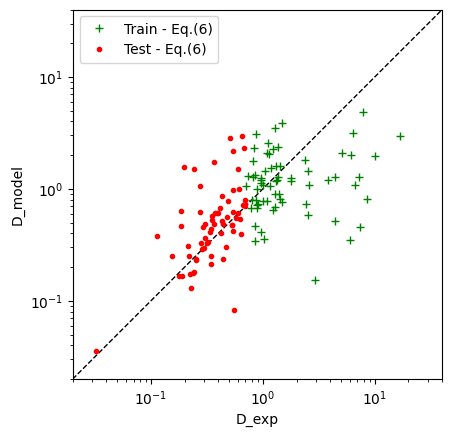

In [5]:
ans=np.array(df_test["D_exp"])
pred=D_model_eq6(param_eq6,df_test)
MSLE_eq6 = ((np.log(1+pred)-np.log(1+ans))**2).mean() # Linear fit
# R2_eq6 = 1 - np.sum((ans-pred)**2)/np.sum((ans-ans.mean())**2)
R2_eq6 = 1 - np.sum((np.log(ans)-np.log(pred))**2)/np.sum((np.log(ans)-np.log(ans).mean())**2)
print("MSLE=",MSLE_eq6, ", R^2=",R2_eq6)

fig=plt.figure()
ax = fig.add_subplot()
D_min = 0.02 #df_all["D_exp"].min()
D_max = 40 #df_all["D_exp"].max()
ax.plot([D_min,D_max],[D_min,D_max],"--",color="k",lw=1)
ax.plot(df_train["D_exp"],D_model_eq6(param_eq6,df_train),"g+",label="Train - Eq.(6)")
ax.plot(df_test["D_exp"],D_model_eq6(param_eq6,df_test),"r.",label="Test - Eq.(6)")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(D_min,D_max)
ax.set_ylim(D_min,D_max)
ax.set_aspect("equal")
ax.set_xlabel("D_exp")
ax.set_ylabel("D_model")
ax.legend()
plt.show()

### Single GP

In [6]:
# data_list = [[np.array(df_train)[:,:12],np.array(df_train["D_exp"])[:,np.newaxis]]] # Linear fit
data_list = [[np.array(df_train)[:,:12],np.log(np.array(df_train["D_exp"])[:,np.newaxis])]] # Log fit
print(data_list[0][0].shape, data_list[0][1].shape)
# model_singlegp = NARGP(data_list = data_list)             
# model_singlegp.optimize(optimize_restarts=20, max_iters=400)


# single_gp_config_list = [
#     {"kernel": KERNEL_NAME},
# ]
# model_singlegp = NARGP(
#     data_list = data_list,
#     single_gp_config_list=single_gp_config_list,
#     normalize=True)
# model_singlegp.optimize()

# if KERNEL_NAME == "RBF":
#     with open("model_singleGP_RBF.pkl","wb") as f:
#         pickle.dump(model_singlegp,f)
# elif KERNEL_NAME == "SpectralMixture":
#     with open("model_singleGP_SMK.pkl","wb") as f:
#         pickle.dump(model_singlegp,f)
# elif KERNEL_NAME == "NeuralKernelNetwork":
#     with open("model_singleGP_NKN.pkl","wb") as f:
#         pickle.dump(model_singlegp,f)


if KERNEL_NAME == "RBF":
    with open("model_singleGP_RBF.pkl","rb") as f:
        model_singlegp = pickle.load(f)
elif KERNEL_NAME == "SpectralMixture":
    with open("model_singleGP_SMK.pkl","rb") as f:
        model_singlegp = pickle.load(f)
elif KERNEL_NAME == "NeuralKernelNetwork":
    with open("model_singleGP_NKN.pkl","rb") as f:
        model_singlegp = pickle.load(f)



(67, 12) (67, 1)


2024-10-26 04:03:21.325988: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/smaeyama/mylib/netcdf-fortran-4.6.1-ifx/lib:/opt/intel/oneapi/tbb/2021.12/env/../lib/intel64/gcc4.8:/opt/intel/oneapi/mpi/2021.12/opt/mpi/libfabric/lib:/opt/intel/oneapi/mpi/2021.12/lib:/opt/intel/oneapi/mkl/2024.1/lib:/opt/intel/oneapi/ippcp/2021.11/lib/:/opt/intel/oneapi/ipp/2021.11/lib:/opt/intel/oneapi/dpl/2022.5/lib:/opt/intel/oneapi/dnnl/2024.1/lib:/opt/intel/oneapi/debugger/2024.1/opt/debugger/lib:/opt/intel/oneapi/dal/2024.2/lib:/opt/intel/oneapi/compiler/2024.1/opt/oclfpga/host/linux64/lib:/opt/intel/oneapi/compiler/2024.1/opt/compiler/lib:/opt/intel/oneapi/compiler/2024.1/lib:/opt/intel/oneapi/ccl/2021.12/lib/
2024-10-26 04:03:21.326050: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
202

MSLE= 0.10943867445910038 , R^2= -1.869392291099456


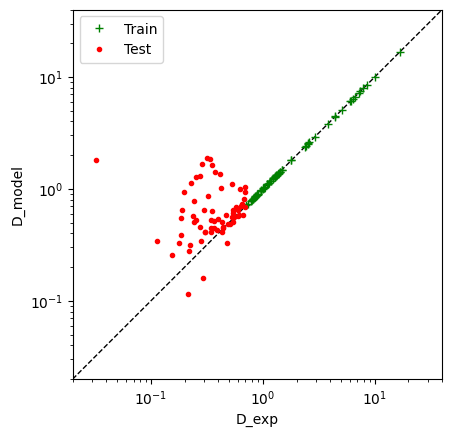

In [7]:
mean_train_1, var_train_1 = model_singlegp.predict(np.array(df_train)[:,:12])
mean_test_1, var_test_1 = model_singlegp.predict(np.array(df_test)[:,:12])

# ### Linear fit ###
# ans=np.array(df_test["D_exp"])
# pred=mean_test.ravel()
### Log fit ###
ans=np.array(df_test["D_exp"])
pred=np.exp(mean_test_1.ravel())

MSLE_singlegp = ((np.log(1+pred)-np.log(1+ans))**2).mean() # Linear fit
# R2 = 1 - np.sum((ans-pred)**2)/np.sum((ans-ans.mean())**2)
R2_singlegp = 1 - np.sum((np.log(ans)-np.log(pred))**2)/np.sum((np.log(ans)-np.log(ans).mean())**2)
print("MSLE=",MSLE_singlegp, ", R^2=",R2_singlegp)

fig=plt.figure()
ax = fig.add_subplot()
D_min = 0.02 #df_all["D_exp"].min()
D_max = 40 #df_all["D_exp"].max()
ax.plot([D_min,D_max],[D_min,D_max],"--",color="k",lw=1)
# ax.plot(df_train["D_exp"],mean_train,"o",label="Train") # Linear fit
# ax.plot(df_test["D_exp"],mean_test,"o",label="Test") # Linear fit
ax.plot(df_train["D_exp"],np.exp(mean_train_1),"g+",label="Train") # Log fit
ax.plot(df_test["D_exp"],np.exp(mean_test_1),"r.",label="Test") # Log fit
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(D_min,D_max)
ax.set_ylim(D_min,D_max)
ax.set_aspect("equal")
ax.set_xlabel("D_exp")
ax.set_ylabel("D_model")
ax.legend()
plt.show()

### Multi-fidelity regression by NARGP
Low-fidelity data: (linearly most unstable wavenumber, growthrate)
High-fidelity data: D_exp

In [8]:
# data_list = [[np.array(df)[:,:12],np.array(df)[:,17:19]],,
#              [np.array(df_train)[:,:12],np.array(df_train["D_exp"])[:,np.newaxis]]] # Linear fit
data_list = [[np.array(df)[:,:12],np.array(df)[:,17:19]],
             [np.array(df_train)[:,:12],np.log(np.array(df_train["D_exp"])[:,np.newaxis])]] # Log fit
print(data_list[0][0].shape, data_list[0][1].shape)
print(data_list[1][0].shape, data_list[1][1].shape)
# model_nargp = NARGP(data_list=data_list)             
# model_nargp.optimize(optimize_restarts=20, max_iters=400)

# single_gp_config_list = [
#     {"kernel": KERNEL_NAME},
#     {"kernel": KERNEL_NAME},
# ]
# model_nargp = NARGP(
#     data_list = data_list,
#     single_gp_config_list=single_gp_config_list,
#     normalize=True)
# model_nargp.optimize()


# if KERNEL_NAME == "RBF":
#     with open("model_NARGP_RBF.pkl","wb") as f:
#         pickle.dump(model_nargp,f)
# elif KERNEL_NAME == "SpectralMixture":
#     with open("model_NARGP_SMK.pkl","wb") as f:
#         pickle.dump(model_nargp,f)
# elif KERNEL_NAME == "NeuralKernelNetwork":
#     with open("model_NARGP_NKN.pkl","wb") as f:
#         pickle.dump(model_nargp,f)


if KERNEL_NAME == "RBF":
    with open("model_NARGP_RBF.pkl","rb") as f:
        model_nargp = pickle.load(f)
elif KERNEL_NAME == "SpectralMixture":
    with open("model_NARGP_SMK.pkl","rb") as f:
        model_nargp = pickle.load(f)
elif KERNEL_NAME == "NeuralKernelNetwork":
    with open("model_NARGP_NKN.pkl","rb") as f:
        model_nargp = pickle.load(f)

(135, 12) (135, 2)
(67, 12) (67, 1)


MSLE= 0.0654379972925166 , R^2= -1.1468925924718416


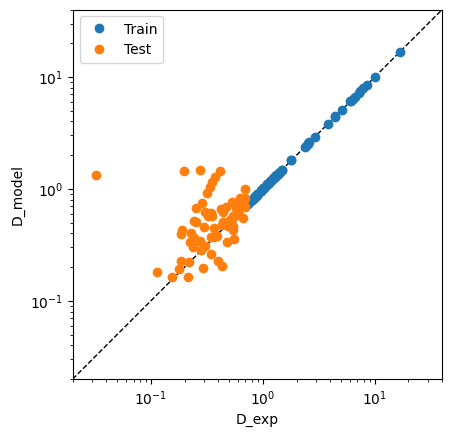

In [9]:
mean_train, var_train = model_nargp.predict(np.array(df_train)[:,:12])
mean_test, var_test = model_nargp.predict(np.array(df_test)[:,:12])
# mean_train = mean_train + np.log(np.array(D_model_eq6(param_eq6,df_train))[:,np.newaxis])
# mean_test = mean_test + np.log(np.array(D_model_eq6(param_eq6,df_test))[:,np.newaxis])

# ### Linear fit ###
# ans=np.array(df_test["D_exp"])
# pred=mean_test.ravel().copy()
### Log fit ###
ans=np.array(df_test["D_exp"])
pred=np.exp(mean_test.ravel())

MSLE=((np.log(1+pred)-np.log(1+ans))**2).mean()
# R2 = 1 - np.sum((ans-pred)**2)/np.sum((ans-ans.mean())**2)
R2 = 1 - np.sum((np.log(ans)-np.log(pred))**2)/np.sum((np.log(ans)-np.log(ans).mean())**2)
print("MSLE=",MSLE, ", R^2=",R2)

fig=plt.figure()
ax = fig.add_subplot()
D_min = 0.02 #df_all["D_exp"].min()
D_max = 40 #df_all["D_exp"].max()
ax.plot([D_min,D_max],[D_min,D_max],"--",color="k",lw=1)
# ax.plot(df_train["D_exp"],mean_train,"o",label="Train") # Linear fit
# ax.plot(df_test["D_exp"],mean_test,"o",label="Test") # Linear fit
ax.plot(df_train["D_exp"],np.exp(mean_train),"o",label="Train") # Log fit
ax.plot(df_test["D_exp"],np.exp(mean_test),"o",label="Test") # Log fit
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(D_min,D_max)
ax.set_ylim(D_min,D_max)
ax.set_aspect("equal")
ax.set_xlabel("D_exp")
ax.set_ylabel("D_model")
ax.legend()
plt.show()

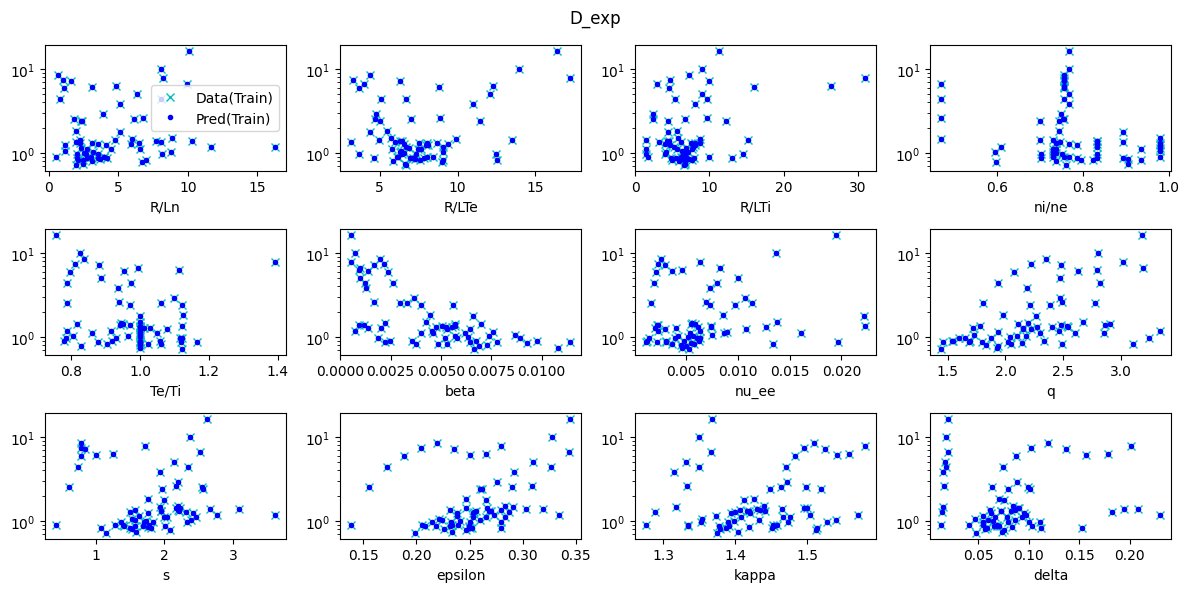

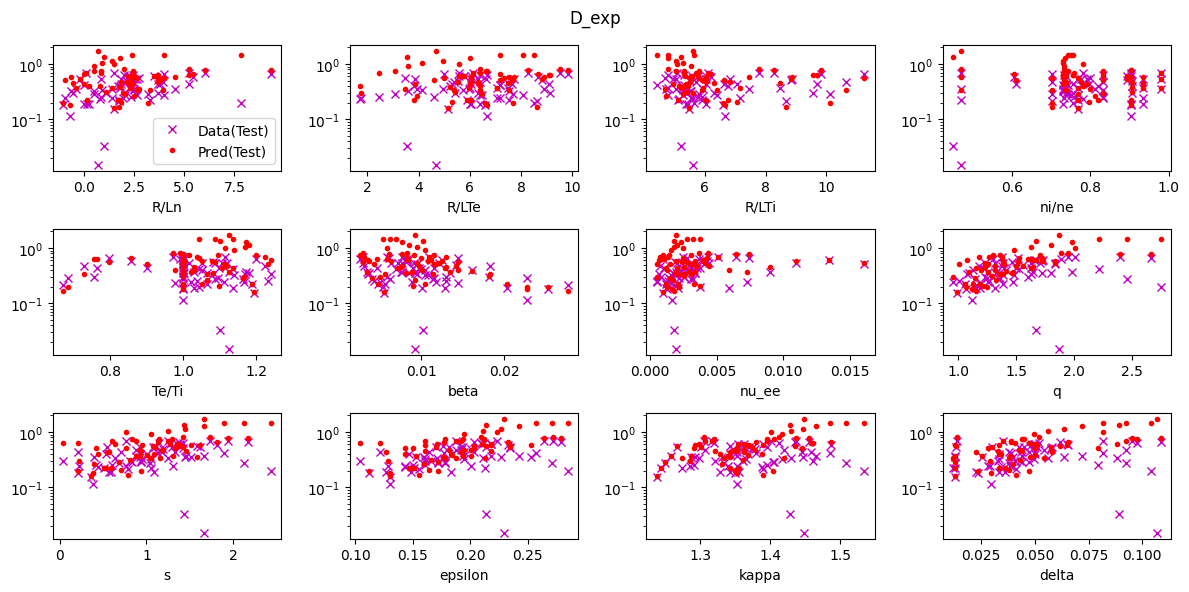

In [10]:
fig = plt.figure(figsize=(12,6))
fig.suptitle("D_exp")
nl=3; nc=4; i=0
for l in range(nl):
    for c in range(nc):
        ax = fig.add_subplot(nl,nc,1+i)
        ax.plot(df_train.iloc[:,i],df_train["D_exp"],"cx",label="Data(Train)")
        # ax.plot(df_test.iloc[:,i],df_test["D_exp"],"mx",label="Data(Test)")
        ax.plot(df_train.iloc[:,i],np.exp(mean_train),"b.",label="Pred(Train)")
        # ax.plot(df_test.iloc[:,i],np.exp(mean_test),"r.",label="Pred(Test)")
        ax.set_xlabel(df_train.columns[i])
        # ax.set_xscale("log")
        ax.set_yscale("log")
        if i==0:
            ax.legend()
        i=i+1
fig.tight_layout()
plt.show()

fig = plt.figure(figsize=(12,6))
fig.suptitle("D_exp")
nl=3; nc=4; i=0
for l in range(nl):
    for c in range(nc):
        ax = fig.add_subplot(nl,nc,1+i)
        # ax.plot(df_train.iloc[:,i],df_train["D_exp"],"cx",label="Data(Train)")
        ax.plot(df_test.iloc[:,i],df_test["D_exp"],"mx",label="Data(Test)")
        # ax.plot(df_train.iloc[:,i],np.exp(mean_train),"b.",label="Pred(Train)")
        ax.plot(df_test.iloc[:,i],np.exp(mean_test),"r.",label="Pred(Test)")
        ax.set_xlabel(df_train.columns[i])
        # ax.set_xscale("log")
        ax.set_yscale("log")
        if i==0:
            ax.legend()
        i=i+1
fig.tight_layout()
plt.show()

### Plot Figure 5

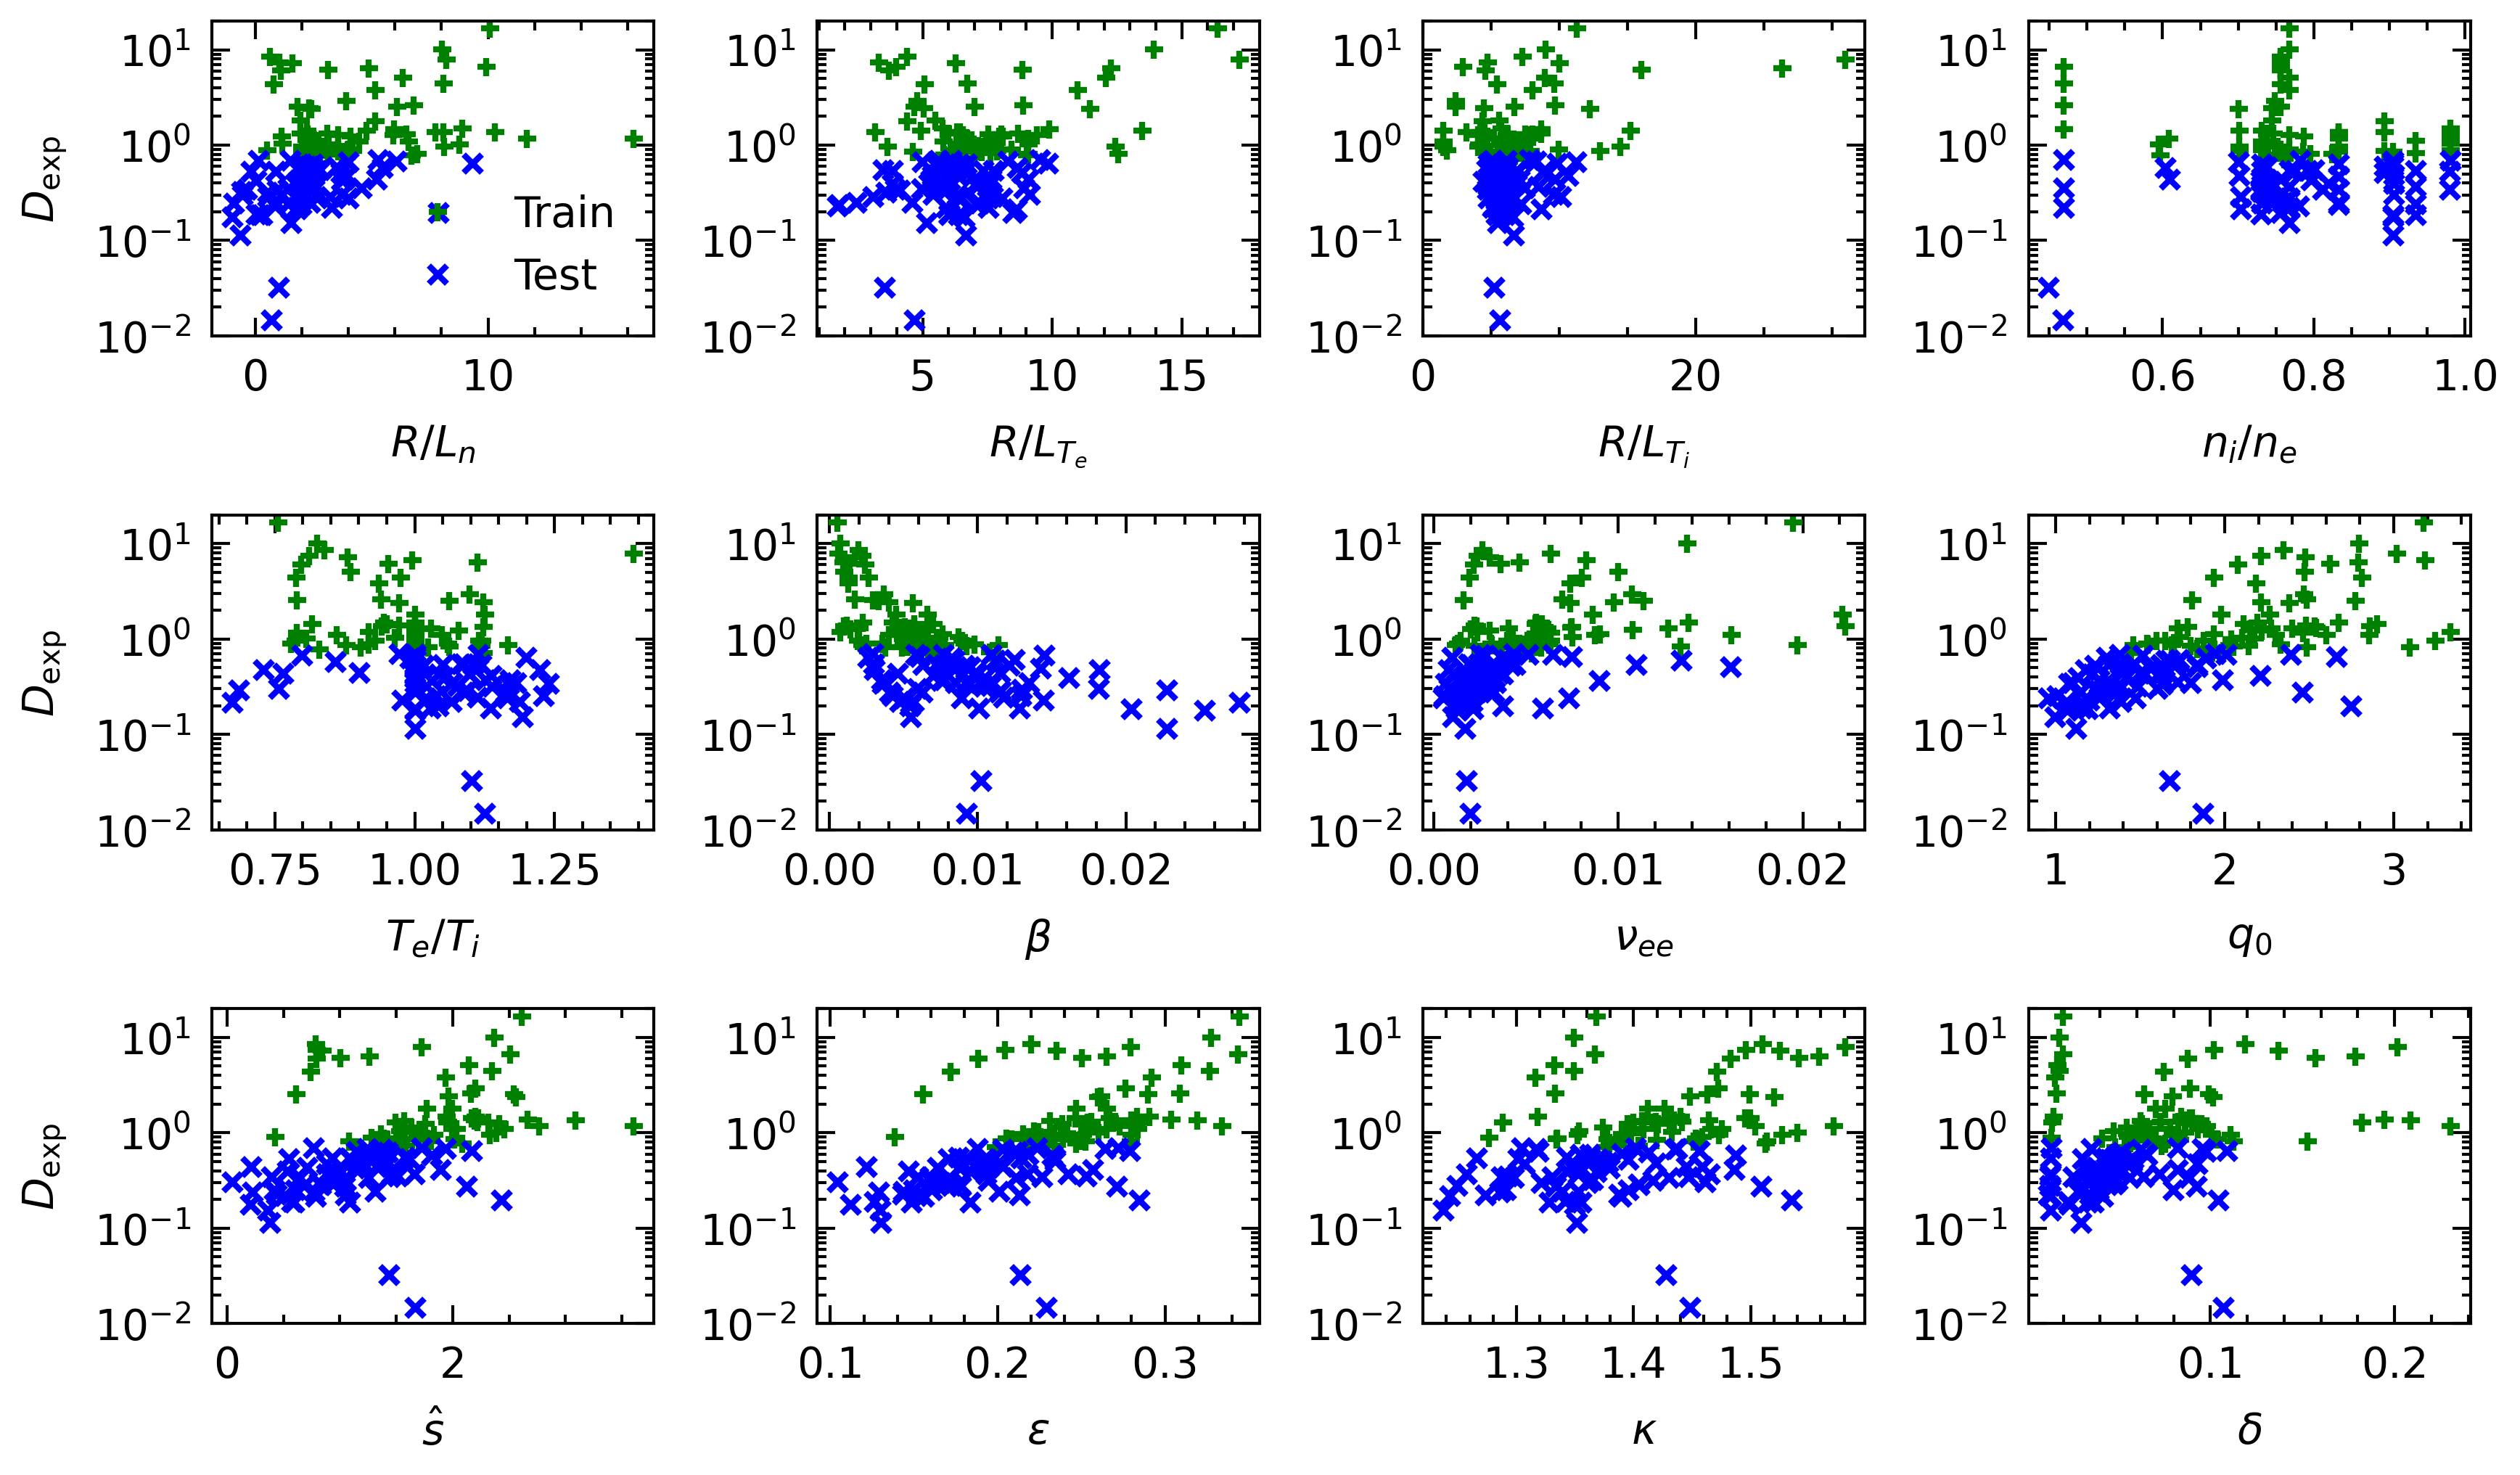

In [11]:
plt.style.use('../nature_style.txt')

fig=plt.figure(figsize=(5.9,3.5),dpi=600) # figsize=(width,height(inch)),dpi(dots per inch)

xlabels = [r"$R/L_n$", r"$R/L_{T_e}$", r"$R/L_{T_i}$", r"$n_i/n_e$", r"$T_e/T_i$", r"$\beta$", r"$\nu_{ee}$", r"$q_0$", r"$\hat{s}$", r"$\epsilon$", r"$\kappa$", r"$\delta$"]
text = ["(a)", "(b)", "(c)", "(d)", "(e)", "(f)", "(g)", "(h)", "(i)", "(j)", "(k)", "(l)"]
# fig.suptitle("D_exp")
nl=3; nc=4; i=0
D_min = 0.01 #df["D_exp"].min()
D_max = 20 #df["D_exp"].max()
for l in range(nl):
    for c in range(nc):
        ax = fig.add_subplot(nl,nc,1+i)
        # ax.plot(df.iloc[:,i],df["D_exp"],"x",label="All data")
        ax.plot(df_train.iloc[:,i],df_train["D_exp"],"g+",lw=1,label="Train")
        ax.plot(df_test.iloc[:,i],df_test["D_exp"],"bx",lw=1,label="Test")
        # ax.plot(np.array(df_test.iloc[:,i])[outliner_list[0]],np.array(df_test["D_exp"])[outliner_list[0]],"x",c="red",label="")
        # ax.plot(np.array(df_test.iloc[:,i])[outliner_list[1]],np.array(df_test["D_exp"])[outliner_list[1]],"*",c="red",label="")
        # ax.plot(np.array(df_test.iloc[:,i])[outliner_list[2]],np.array(df_test["D_exp"])[outliner_list[2]],"^",c="red",label="")
        # ax.plot(np.array(df_test.iloc[:,i])[outliner_list[3]],np.array(df_test["D_exp"])[outliner_list[3]],"s",c="red",label="Outliner")
        ax.set_xlabel(xlabels[i])
        # ax.set_xscale("log")
        ax.set_yscale("log")
        ax.set_ylim(D_min,D_max)
        # if i==7 or i==9 or i==10:
        #     ax.text(0.05, 0.82,text[i],color="k", fontfamily="sans-serif", fontweight="bold", fontsize=8, transform=ax.transAxes)
        # else:
        #     ax.text(0.835, 0.82,text[i],color="k", fontfamily="sans-serif", fontweight="bold", fontsize=8, transform=ax.transAxes)
        if c==0:
            ax.set_ylabel(r"$D_\mathrm{exp}$")
        if i==0:
            ax.legend()
        i=i+1
fig.tight_layout()
plt.savefig("fig5.pdf",dpi=600,bbox_inches="tight")
plt.show() 

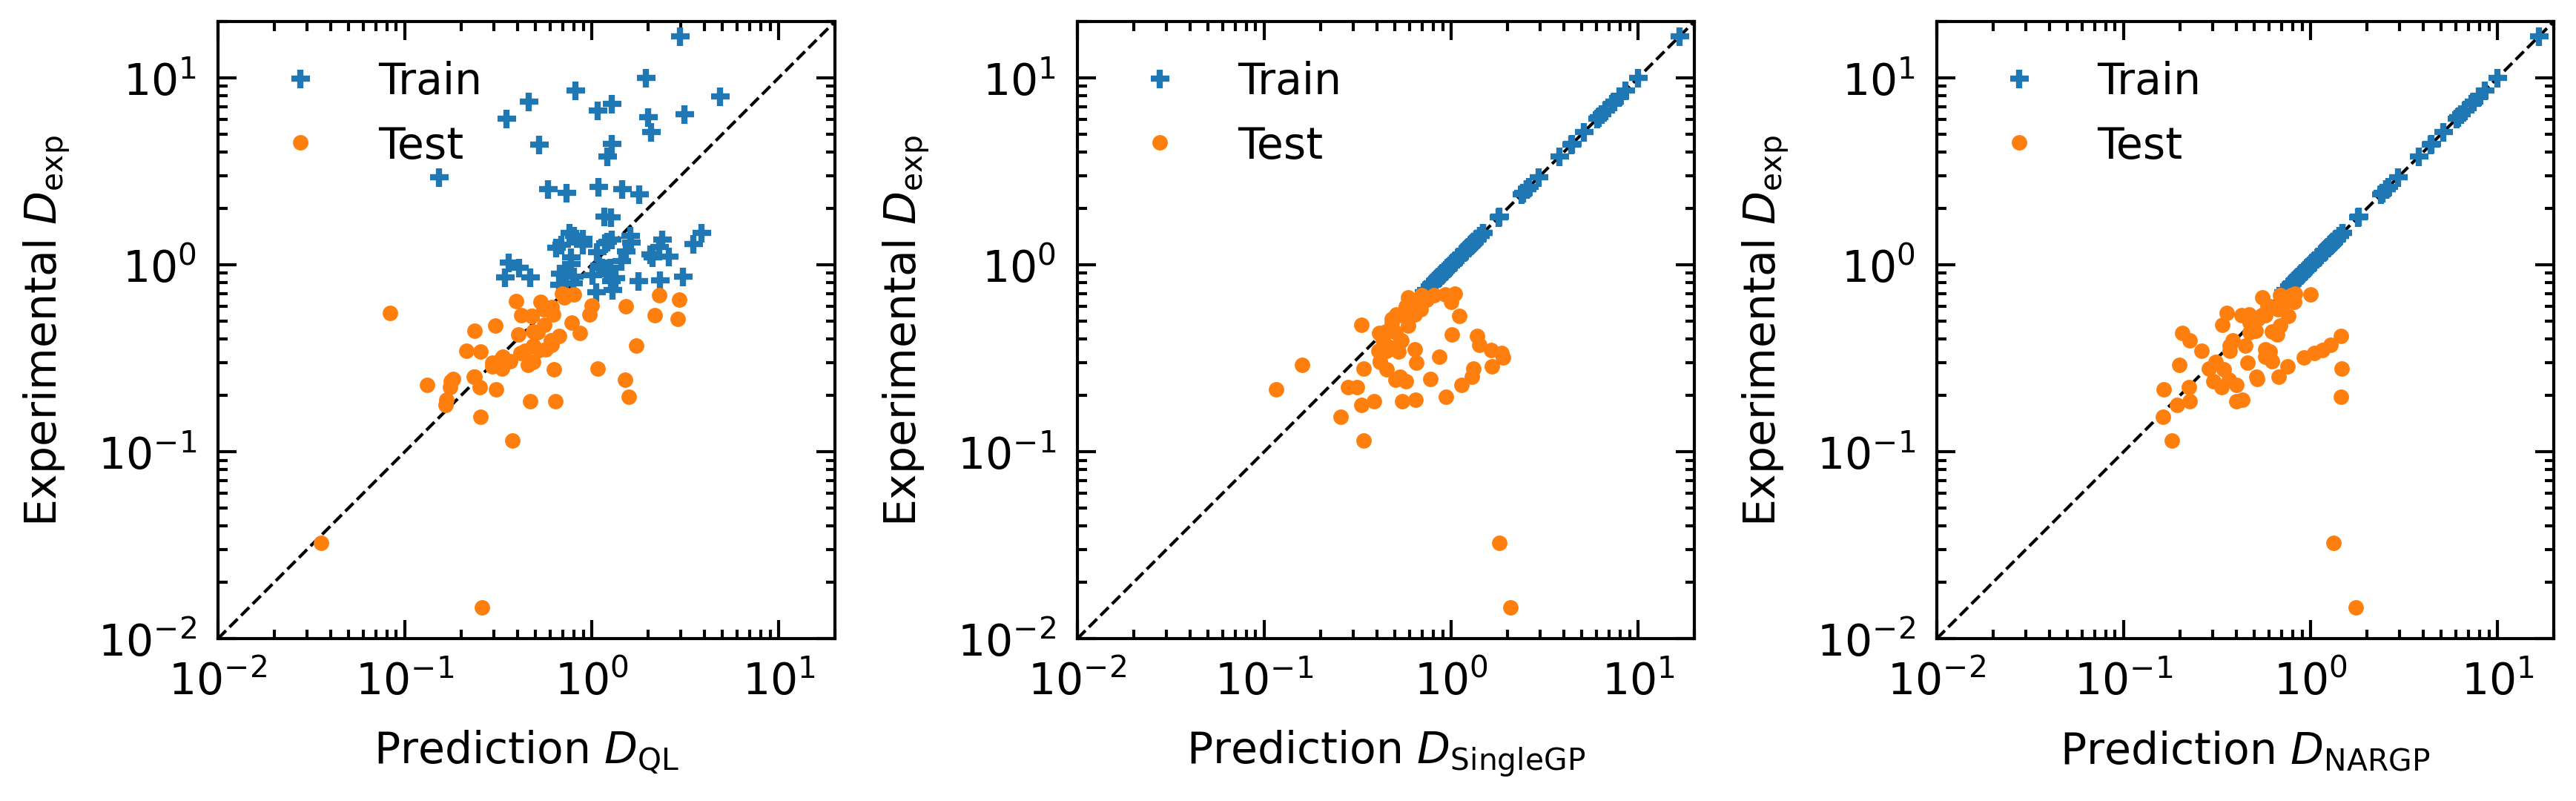

In [12]:
plt.style.use('../nature_style.txt')

fig=plt.figure(figsize=(5.9,3),dpi=600) # figsize=(width,height(inch)),dpi(dots per inch)

ax = fig.add_subplot(1,3,1)
D_min = 0.01 #df["D_exp"].min()
D_max = 20 #df["D_exp"].max()
ax.plot([D_min,D_max],[D_min,D_max],"--",color="k",lw=0.5)
ax.plot(D_model_eq6(param_eq6,df_train),df_train["D_exp"],"+",label="Train")
ax.plot(D_model_eq6(param_eq6,df_test),df_test["D_exp"],".",label="Test")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(D_min,D_max)
ax.set_ylim(D_min,D_max)
ax.set_aspect("equal")
ax.set_aspect("equal")
ax.set_xlabel(r"Prediction $D_\mathrm{QL}$")
ax.set_ylabel(r"Experimental $D_\mathrm{exp}$")
ax.legend(loc="upper left")
# ax.text(0.015,9,"(a)",color="k", fontfamily="sans-serif", fontweight="bold", fontsize=8)

ax = fig.add_subplot(1,3,2)
D_min = 0.01 #df["D_exp"].min()
D_max = 20 #df["D_exp"].max()
ax.plot([D_min,D_max],[D_min,D_max],"--",color="k",lw=0.5)
ax.plot(np.exp(mean_train_1),df_train["D_exp"],"+",label="Train")
ax.plot(np.exp(mean_test_1),df_test["D_exp"],".",label="Test")
outliner_list = [18,84,44,17]
# ax.plot(np.exp(mean_test_1)[outliner_list[0]],np.array(df_test["D_exp"])[outliner_list[0]],"x",c="red",label="")
# ax.plot(np.exp(mean_test_1)[outliner_list[1]],np.array(df_test["D_exp"])[outliner_list[1]],"*",c="red",label="")
# ax.plot(np.exp(mean_test_1)[outliner_list[2]],np.array(df_test["D_exp"])[outliner_list[2]],"^",c="red",label="")
# ax.plot(np.exp(mean_test_1)[outliner_list[3]],np.array(df_test["D_exp"])[outliner_list[3]],"s",c="red",label="Outliner")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(D_min,D_max)
ax.set_ylim(D_min,D_max)
ax.set_aspect("equal")
ax.set_aspect("equal")
ax.set_xlabel(r"Prediction $D_\mathrm{SingleGP}$")
ax.set_ylabel(r"Experimental $D_\mathrm{exp}$")
ax.legend(loc="upper left")
# ax.text(0.015,9,"(b)",color="k", fontfamily="sans-serif", fontweight="bold", fontsize=8)

ax = fig.add_subplot(1,3,3)
D_min = 0.01 #df["D_exp"].min()
D_max = 20 #df["D_exp"].max()
ax.plot([D_min,D_max],[D_min,D_max],"--",color="k",lw=0.5)
ax.plot(np.exp(mean_train),df_train["D_exp"],"+",label="Train")
ax.plot(np.exp(mean_test),df_test["D_exp"],".",label="Test")
# ax.plot(np.exp(mean_test)[outliner_list[0]],np.array(df_test["D_exp"])[outliner_list[0]],"x",c="red",label="")
# ax.plot(np.exp(mean_test)[outliner_list[1]],np.array(df_test["D_exp"])[outliner_list[1]],"*",c="red",label="")
# ax.plot(np.exp(mean_test)[outliner_list[2]],np.array(df_test["D_exp"])[outliner_list[2]],"^",c="red",label="")
# ax.plot(np.exp(mean_test)[outliner_list[3]],np.array(df_test["D_exp"])[outliner_list[3]],"s",c="red",label="Outliner")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(D_min,D_max)
ax.set_ylim(D_min,D_max)
ax.set_aspect("equal")
ax.set_aspect("equal")
ax.set_xlabel(r"Prediction $D_\mathrm{NARGP}$")
ax.set_ylabel(r"Experimental $D_\mathrm{exp}$")
ax.legend(loc="upper left")
# ax.text(0.015,9,"(c)",color="k", fontfamily="sans-serif", fontweight="bold", fontsize=8)

plt.tight_layout()
plt.savefig("fig6.pdf",dpi=600,bbox_inches="tight")
plt.show() 

(68, 13) (67, 13) (4556,)
(68, 67)
(68,)
[ True False False False False  True False False False False False False
  True False False False False False  True False False False False False
 False  True False False False False False False False  True False False
  True False False False False  True False False False False  True False
 False  True False False  True False False False False False False  True
 False False False False  True  True  True  True]


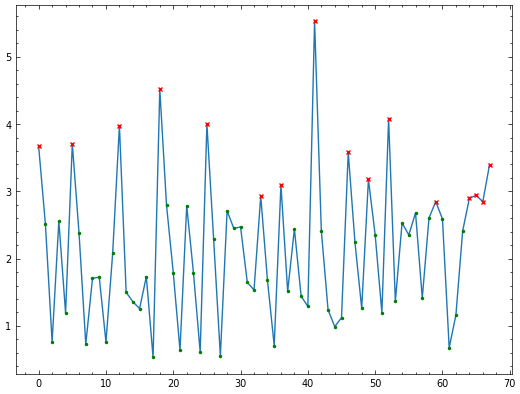

In [37]:
from scipy.spatial import distance
# test_points = np.array(df_test.iloc[:,0:12])
# train_points = np.array(df_train.iloc[:,0:12])
# all_points = np.array(df.iloc[:,0:12])
test_points = np.concatenate([df_test.iloc[:,0:12],df_test.iloc[:,19:20]],axis=1)
train_points = np.concatenate([df_train.iloc[:,0:12],df_train.iloc[:,19:20]],axis=1)
all_points = np.concatenate([df.iloc[:,0:12],df.iloc[:,19:20]],axis=1)
covariance_matrix = np.cov(all_points.T)
#inv_covariance_matrix = np.linalg.inv(covariance_matrix)
inv_covariance_matrix = np.linalg.pinv(covariance_matrix)

distances_of_test_from_train = np.array([distance.mahalanobis(x, y, inv_covariance_matrix)
                          for x in test_points for y in train_points])
print(test_points.shape,train_points.shape,distances_of_test_from_train.shape)
distances_of_test_from_train = distances_of_test_from_train.reshape(test_points.shape[0], len(train_points))
print(distances_of_test_from_train.shape)
min_distances_of_test_from_train_dataset = np.min(distances_of_test_from_train, axis=1)
print(min_distances_of_test_from_train_dataset.shape)

far_list = min_distances_of_test_from_train_dataset>2.8
near_list = min_distances_of_test_from_train_dataset<=2.8
print(far_list)
plt.plot(min_distances_of_test_from_train_dataset)
# plt.plot(outliner_list,min_distances_of_test_from_train_dataset[outliner_list],"o")
plt.plot(np.arange(len(far_list))[far_list],min_distances_of_test_from_train_dataset[far_list],"x",c="red")
plt.plot(np.arange(len(near_list))[near_list],min_distances_of_test_from_train_dataset[near_list],".",c="green")
plt.show()

(68, 13) (67, 13) (4556,)
(68, 67)
(68,)
[ True False False False False False False False False False False False
  True False False False False False  True  True False False False False
 False  True False False False False False False False False False False
 False False False False False  True  True False False False  True  True
 False  True False False  True False False False False False False False
 False False False False False False  True  True]


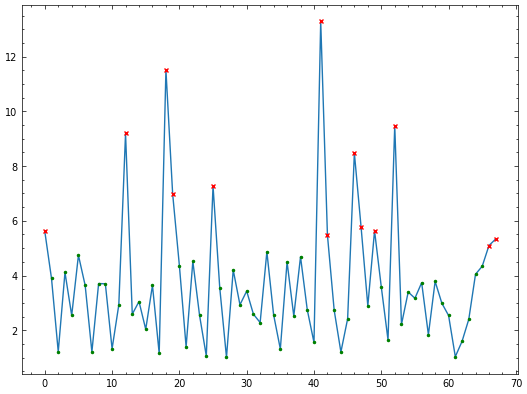

In [42]:
from scipy.spatial import distance
# test_points = np.array(df_test.iloc[:,0:12])
# train_points = np.array(df_train.iloc[:,0:12])
# all_points = np.array(df.iloc[:,0:12])
# test_points = np.concatenate([df_test.iloc[:,0:12],df_test.iloc[:,19:20]],axis=1)
# train_points = np.concatenate([df_train.iloc[:,0:12],df_train.iloc[:,19:20]],axis=1)
# all_points = np.concatenate([df.iloc[:,0:12],df.iloc[:,19:20]],axis=1)
test_points = np.concatenate([df_test.iloc[:,0:12],np.log(df_test.iloc[:,19:20])],axis=1)
train_points = np.concatenate([df_train.iloc[:,0:12],np.log(df_train.iloc[:,19:20])],axis=1)
all_points = np.concatenate([df.iloc[:,0:12],np.log(df.iloc[:,19:20])],axis=1)
covariance_matrix = np.cov(train_points.T)
#inv_covariance_matrix = np.linalg.inv(covariance_matrix)
inv_covariance_matrix = np.linalg.pinv(covariance_matrix)

distances_of_test_from_train = np.array([distance.mahalanobis(x, y, inv_covariance_matrix)
                          for x in test_points for y in train_points])
print(test_points.shape,train_points.shape,distances_of_test_from_train.shape)
distances_of_test_from_train = distances_of_test_from_train.reshape(test_points.shape[0], len(train_points))
print(distances_of_test_from_train.shape)
min_distances_of_test_from_train_dataset = np.min(distances_of_test_from_train, axis=1)
print(min_distances_of_test_from_train_dataset.shape)

far_list = min_distances_of_test_from_train_dataset>5
near_list = min_distances_of_test_from_train_dataset<=5
print(far_list)
plt.plot(min_distances_of_test_from_train_dataset)
# plt.plot(outliner_list,min_distances_of_test_from_train_dataset[outliner_list],"o")
plt.plot(np.arange(len(far_list))[far_list],min_distances_of_test_from_train_dataset[far_list],"x",c="red")
plt.plot(np.arange(len(near_list))[near_list],min_distances_of_test_from_train_dataset[near_list],".",c="green")
plt.show()

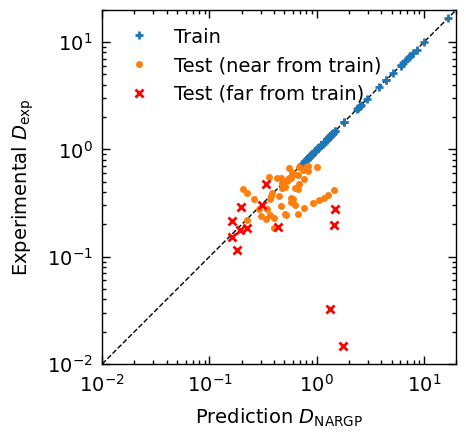

In [43]:
fig=plt.figure(figsize=(2.3,2.3),dpi=200)
ax=fig.add_subplot()
D_min = 0.01 #df["D_exp"].min()
D_max = 20 #df["D_exp"].max()
ax.plot([D_min,D_max],[D_min,D_max],"--",color="k",lw=0.5)
ax.plot(np.exp(mean_train),df_train["D_exp"],"+",label="Train")
# ax.plot(np.exp(mean_test_1),df_test["D_exp"],".",label="Test")
ax.plot(np.exp(mean_test)[near_list],np.array(df_test["D_exp"])[near_list],".",label="Test (near from train)")
ax.plot(np.exp(mean_test)[far_list],np.array(df_test["D_exp"])[far_list],"x",c="red",label="Test (far from train)")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(D_min,D_max)
ax.set_ylim(D_min,D_max)
ax.set_aspect("equal")
ax.set_aspect("equal")
ax.set_xlabel(r"Prediction $D_\mathrm{NARGP}$")
ax.set_ylabel(r"Experimental $D_\mathrm{exp}$")
ax.legend(loc="upper left")
fig.savefig("Mah.pdf")
plt.show()